<a href="https://colab.research.google.com/github/2300080003/OPENCV-PROJECT/blob/main/opencv_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1: Upload LEFT image file when prompted.
Upload LEFT image (e.g., left.jpg):


Saving aesthetic ribbon pink wallpaper.jpeg to aesthetic ribbon pink wallpaper.jpeg

STEP 2: Click once on the POINT in the LEFT image that you want to triangulate.
Left click coords (image pixels): (250, 145)

STEP 3: Upload RIGHT image file when prompted.
Upload RIGHT image (e.g., right.jpg):


Saving ocean.jpeg to ocean.jpeg

STEP 4: Click ONCE on the SAME physical point in the RIGHT image.
Right click coords (image pixels): (438, 285)

--- RESULT ---
Selected pixel coordinates:
 Left  (x1,y1) = (250, 145)
 Right (x2,y2) = (438, 285)

Estimated 3D coordinates (in the same distance units used in T):
 X = -0.041495
 Y = -0.008903
 Z = 0.284651

Confirmation (images with selected point marked):


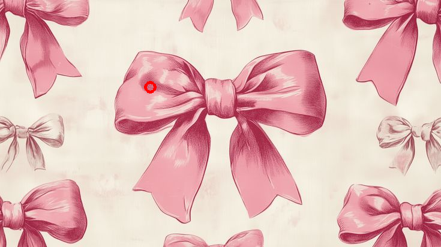

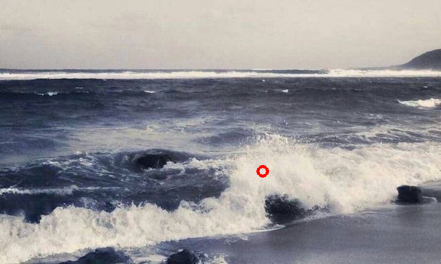

In [ ]:


import cv2
import numpy as np
from google.colab import files, output
from IPython.display import display, HTML
import base64
from io import BytesIO
from PIL import Image

def upload_image(prompt="Upload image:"):
    print(prompt)
    uploaded = files.upload()
    if len(uploaded) == 0:
        raise RuntimeError("No file uploaded.")
    filename = list(uploaded.keys())[0]
    # Read as BGR (cv2)
    img_bgr = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise RuntimeError("Failed to read image.")
    # Also keep RGB PIL for base64 encode
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img_rgb)
    buffered = BytesIO()
    pil.save(buffered, format="PNG")
    b64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return filename, img_bgr, b64, pil.size  # returns (name, bgr, base64, (w,h))

def get_click_coords_from_base64(b64_image, title="Click the image"):
    """
    Displays image (via JS) and waits for a single click.
    Returns (x, y) in image pixel coordinates (natural image size).
    """
    js = f"""
    new Promise((resolve) => {{
      // create container
      const container = document.createElement('div');
      container.style.display = 'flex';
      container.style.flexDirection = 'column';
      container.style.alignItems = 'center';
      container.style.justifyContent = 'center';
      container.style.margin = '4px 0px';
      // title
      const t = document.createElement('div');
      t.innerText = "{title}";
      t.style.fontWeight = '600';
      t.style.marginBottom = '4px';
      container.appendChild(t);

      // image
      const img = new Image();
      img.src = "data:image/png;base64,{b64_image}";
      img.style.maxWidth = '90%';
      img.style.height = 'auto';
      img.style.cursor = 'crosshair';
      img.style.boxShadow = '0 0 6px rgba(0,0,0,0.3)';
      container.appendChild(img);

      // helper text
      const hint = document.createElement('div');
      hint.innerText = "Click exactly once on the image to select the point.";
      hint.style.fontSize = '12px';
      hint.style.marginTop = '4px';
      container.appendChild(hint);

      document.body.appendChild(container);

      img.onload = () => {{
        // Wait for click
        img.onclick = (e) => {{
          // offsetX/Y are relative to the displayed image
          const dispX = e.offsetX;
          const dispY = e.offsetY;
          // natural size -> actual pixels
          const scaleX = img.naturalWidth / img.width;
          const scaleY = img.naturalHeight / img.height;
          const x = Math.round(dispX * scaleX);
          const y = Math.round(dispY * scaleY);

          // cleanup
          container.remove();
          resolve([x, y]);
        }};
      }};
    }});
    """
    coords = output.eval_js(js)  # returns a JS array mapped to Python list
    # coords is like [x,y]
    return int(coords[0]), int(coords[1])

# -------------------------
# Main interactive sequence
# -------------------------
print("STEP 1: Upload LEFT image file when prompted.")
left_name, left_bgr, left_b64, left_size = upload_image("Upload LEFT image (e.g., left.jpg):")

# show and click on left
print("\nSTEP 2: Click once on the POINT in the LEFT image that you want to triangulate.")
x1, y1 = get_click_coords_from_base64(left_b64, title=f"LEFT: {left_name}")

print(f"Left click coords (image pixels): ({x1}, {y1})")

print("\nSTEP 3: Upload RIGHT image file when prompted.")
right_name, right_bgr, right_b64, right_size = upload_image("Upload RIGHT image (e.g., right.jpg):")

# show and click on right
print("\nSTEP 4: Click ONCE on the SAME physical point in the RIGHT image.")
x2, y2 = get_click_coords_from_base64(right_b64, title=f"RIGHT: {right_name}")

print(f"Right click coords (image pixels): ({x2}, {y2})")

# -------------------------
# Triangulation parameters
# -------------------------
# NOTE: Replace these with your camera calibration values for real results.
# Example intrinsics (fx, fy, cx, cy)
K1 = np.array([[800, 0, 320],
               [0, 800, 240],
               [0,   0,   1]], dtype=float)

K2 = K1.copy()

# example extrinsics: cameras aligned with a baseline along x of 0.1 m
R = np.eye(3)
T = np.array([[0.1], [0.0], [0.0]])  # 10 cm baseline

P1 = K1 @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K2 @ np.hstack((R, T))

# Prepare points for OpenCV triangulatePoints (they expect shape (2, N) as float32)
p1 = np.array([[x1], [y1]], dtype=np.float32)
p2 = np.array([[x2], [y2]], dtype=np.float32)

# Triangulate (returns homogeneous 4xN)
point_4d = cv2.triangulatePoints(P1, P2, p1, p2)

# Convert homogeneous to 3D
point_4d /= point_4d[3]
X, Y, Z = point_4d[:3,0]

print("\n--- RESULT ---")
print("Selected pixel coordinates:")
print(f" Left  (x1,y1) = ({x1}, {y1})")
print(f" Right (x2,y2) = ({x2}, {y2})")
print("\nEstimated 3D coordinates (in the same distance units used in T):")
print(f" X = {float(X):.6f}")
print(f" Y = {float(Y):.6f}")
print(f" Z = {float(Z):.6f}")

# Show small confirmation thumbnails with markers (inline)
def mark_and_show(bgr_img, x, y, title=""):
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    vis = rgb.copy()
    # clip coords to image bounds
    h, w = vis.shape[:2]
    xc = int(np.clip(x, 0, w-1))
    yc = int(np.clip(y, 0, h-1))
    cv2.circle(vis, (xc, yc), 8, (255,0,0), 3)  # red circle
    display(HTML(f"<b>{title}</b>"))
    display(Image.fromarray(vis).resize((int(w*0.6), int(h*0.6))))

print("\nConfirmation (images with selected point marked):")
mark_and_show(left_bgr, x1, y1, title=f"Left: {left_name}")
mark_and_show(right_bgr, x2, y2, title=f"Right: {right_name}")

